In [6]:
import numpy as np
import json
from scipy.stats import pearsonr
import os
from dotenv import load_dotenv
from tqdm import tqdm

In [ ]:
load_dotenv()
dataset_path = os.getenv("DATASET_PATH")
instruments = os.getenv("INSTRUMENTS").split(",")

In [3]:
with open(os.path.join(dataset_path, "dataset_metadata.json"), "r") as f:
    dataset_metadata = json.load(f)

In [4]:
for artist, songs in list(dataset_metadata.items()):
    for song in list(songs.keys()):
        if dataset_metadata[artist][song]["layout"] is None or None in dataset_metadata[artist][song]["layout"]:
            print(f"Removing {artist} - {song}: invalid layout")
            del dataset_metadata[artist][song]
            continue
        if sorted(dataset_metadata[artist][song]["layout"]) != sorted(instruments):
            print(f"Removing {artist} - {song}: instrument mismatch")
            del dataset_metadata[artist][song]
        
        elif dataset_metadata[artist][song]["face_detected"] != True:
            print(f"Removing {artist} - {song}: no face detected")
            del dataset_metadata[artist][song]

    if len(dataset_metadata[artist]) == 0:
        del dataset_metadata[artist]


Removing Abhiram Bode - Devi Pavane: no face detected
Removing Abhiram Bode - Nadatina: no face detected
Removing Abhishek Ravi Shankar - Brindavanam Idhuvo: instrument mismatch
Removing Abhishek Ravi Shankar - Kamakshi Varlakshmi: instrument mismatch
Removing Abhishek Ravi Shankar - Manasa Etulo: instrument mismatch
Removing Abhishek Ravi Shankar - Palaya Sada: instrument mismatch
Removing Abhishek Ravi Shankar - Sami Ninne: instrument mismatch
Removing Abhishek Ravi Shankar - Tappagane Vachunna: invalid layout
Removing Aditi Prahalad - Parama Pavana Rama: no face detected
Removing Aditya Narayanan - Chittam Irangadhe: instrument mismatch
Removing Aditya Narayanan - Koluvamaragada: instrument mismatch
Removing Aditya Narayanan - Sarasaksha Palaya: instrument mismatch
Removing Ameya Karthikeyan - Jalajakshi: no face detected
Removing Ameya Karthikeyan - Saraguna Palimpa: no face detected
Removing Ameya Karthikeyan - iniyagilum ninai: invalid layout
Removing Anjanathirumalai - Durusuga 

In [5]:
print(f"number of artists after filtering: {len(dataset_metadata)}")
print(f"number of songs after filtering: {sum(len(songs) for songs in dataset_metadata.values())}")

number of artists after filtering: 21
number of songs after filtering: 87


In [8]:
motion_features = {}
audio_features = {}

for artist, songs in tqdm(dataset_metadata.items(), desc="Artists"):
    artist_dir = os.path.join(dataset_path, artist)
    if not os.path.isdir(artist_dir) or artist.startswith("."):
        continue

    motion_features.setdefault(artist, {})
    audio_features.setdefault(artist, {})

    for song in tqdm(songs, desc="Songs", leave=False):
        song_dir = os.path.join(artist_dir, song)
        if not os.path.isdir(song_dir) or song.startswith("."):
            continue

        motion_features[artist].setdefault(song, {})
        audio_features[artist].setdefault(song, {})

        instrument_dir = os.path.join(song_dir, "vocal")
        if not os.path.exists(instrument_dir):
            continue

        try:
            with open(
                os.path.join(instrument_dir, "vocal_motion_features.json"), "r"
            ) as f:
                motion_features[artist][song]= json.load(f)
            with open(
                os.path.join(instrument_dir, "audio_features.json"), "r"
            ) as f:
                audio_features[artist][song]= json.load(f)
        except FileNotFoundError:
            print(
                f"File not found for {artist}/{song}. Skipping this instrument."
            )
            continue

Artists: 100%|██████████| 21/21 [00:00<00:00, 34.07it/s]


In [2]:
# Define the paths to the JSON files
vocal_motion_features_path = '/home/gabriel/theo/masters-thesis/dataset/Ameya Karthikeyan/Jalajakshi/vocal/vocal_motion_features.json'
motion_features_path = '/home/gabriel/theo/masters-thesis/dataset/Ameya Karthikeyan/Jalajakshi/vocal/motion_features.json'
audio_features_path = '/home/gabriel/theo/masters-thesis/dataset/Ameya Karthikeyan/Jalajakshi/vocal/audio_features.json'

# Load the vocal motion features from the JSON file
with open(vocal_motion_features_path, 'r') as f:
    vocal_motion_features = json.load(f)

# Load the motion features from the JSON file
with open(motion_features_path, 'r') as f:
    motion_features = json.load(f)

# Load the audio features from the JSON file
with open(audio_features_path, 'r') as f:
    audio_features = json.load(f)

In [9]:
def safe_pearsonr(x, y):
    """
    Compute Pearson correlation between x and y, ignoring NaNs.

    Returns (corr, pval). If too few valid values, returns (np.nan, np.nan).
    """
    x = np.array(x)
    y = np.array(y)
    mask = ~np.isnan(x) & ~np.isnan(y)
    if np.sum(mask) < 2:  # need at least 2 points to compute correlation
        return np.nan, np.nan
    return pearsonr(x[mask], y[mask])

In [10]:
def sliding_correlation(
    signal1, signal2, window_size, step_size, fps, threshold=0.3
):
    assert len(signal1) == len(signal2), "Signals must be the same length"

    correlations = []
    pvals = []
    times = []
    for start in range(0, len(signal1) - window_size + 1, step_size):
        end = start + window_size
        seg1 = signal1[start:end]
        seg2 = signal2[start:end]

        corr, pval = safe_pearsonr(seg1, seg2)
        correlations.append(corr)
        pvals.append(pval)
        times.append(start / fps)

    strong_corr_times = [
        (t,c)
        for t, c, p in zip(times, correlations, pvals)
        if not np.isnan(p)
        and p < 0.05
        and not np.isnan(c)
        and abs(c) > threshold
    ]

    return np.array(correlations), np.array(times), strong_corr_times

In [ ]:
# Motion features we want to analyze
motion_features_to_analyze = ["mouth_area", "jaw_to_nose"]

# Initialize results dictionary
vocal_strong_windows = {
    artist: {
        song: {
        }
    }
}

fps = 30
window_size = int(0.5 * fps)  # 0.5 second windows
step_size = int(0.1 * fps)    # 0.1 second steps

print(f"Analyzing {artist} - {song}")
print(f"Window size: {window_size} frames ({window_size/fps:.1f}s)")
print(f"Step size: {step_size} frames ({step_size/fps:.1f}s)")

# Get the audio features
audio_onset_env = audio_features["onset_env"]
audio_rms = audio_features["rms"]

for motion_feature in motion_features_to_analyze:
    if motion_feature not in vocal_strong_windows[artist][song]:
        vocal_strong_windows[artist][song][motion_feature] = {}
    
    print(f"\nAnalyzing {motion_feature}...")
    
    # Get the motion feature data
    motion_data = vocal_motion_features[motion_feature]
    
    # Compute sliding correlation with onset_env
    correlations_onset, times_onset, strong_correlation_windows_onset = sliding_correlation(
        motion_data,
        audio_onset_env,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Compute sliding correlation with rms
    correlations_rms, times_rms, strong_correlation_windows_rms = sliding_correlation(
        motion_data,
        audio_rms,
        window_size,
        step_size,
        fps,
        threshold=0.5  # Strong correlation threshold
    )
    
    # Store results
    vocal_strong_windows[artist][song][motion_feature] = {
        "correlations_onset": correlations_onset.tolist(),
        "times_onset": times_onset.tolist(),
        "strong_windows_onset": strong_correlation_windows_onset,
        "num_strong_windows_onset": len(strong_correlation_windows_onset),
        "correlations_rms": correlations_rms.tolist(),
        "times_rms": times_rms.tolist(),
        "strong_windows_rms": strong_correlation_windows_rms,
        "num_strong_windows_rms": len(strong_correlation_windows_rms)
    }
    
    print(f"Found {len(strong_correlation_windows_onset)} strong correlation windows for {motion_feature} (onset_env)")
    if strong_correlation_windows_onset:
        print("Strong correlation periods (onset_env):")
        for time, corr in strong_correlation_windows_onset:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

    print(f"Found {len(strong_correlation_windows_rms)} strong correlation windows for {motion_feature} (rms)")
    if strong_correlation_windows_rms:
        print("Strong correlation periods (rms):")
        for time, corr in strong_correlation_windows_rms:
            print(f"  Time: {time:.2f}s, Correlation: {corr:.3f}")

Analyzing Ameya Karthikeyan - Jalajakshi - vocal
Window size: 15 frames (0.5s)
Step size: 3 frames (0.1s)

Analyzing mouth_area...
Found 26 strong correlation windows for mouth_area (onset_env)
Strong correlation periods (onset_env):
  Time: 3.40s, Correlation: -0.561
  Time: 4.20s, Correlation: -0.517
  Time: 9.90s, Correlation: -0.645
  Time: 12.70s, Correlation: -0.540
  Time: 12.80s, Correlation: -0.545
  Time: 12.90s, Correlation: -0.558
  Time: 13.00s, Correlation: -0.562
  Time: 13.10s, Correlation: -0.654
  Time: 19.10s, Correlation: -0.621
  Time: 19.50s, Correlation: -0.781
  Time: 21.40s, Correlation: 0.739
  Time: 21.50s, Correlation: 0.632
  Time: 21.60s, Correlation: 0.747
  Time: 21.70s, Correlation: 0.759
  Time: 23.30s, Correlation: 0.529
  Time: 24.70s, Correlation: -0.666
  Time: 24.80s, Correlation: -0.587
  Time: 24.90s, Correlation: -0.567
  Time: 26.00s, Correlation: 0.646
  Time: 26.20s, Correlation: 0.522
  Time: 27.20s, Correlation: 0.524
  Time: 29.80s, Corre

Found 29 strong correlation windows for jaw_to_nose (onset_env)
Strong correlation periods (onset_env):
  Time: 4.20s, Correlation: -0.589
  Time: 4.30s, Correlation: -0.694
  Time: 5.00s, Correlation: 0.570
  Time: 9.90s, Correlation: -0.676
  Time: 12.60s, Correlation: 0.541
  Time: 12.90s, Correlation: -0.605
  Time: 13.00s, Correlation: -0.579
  Time: 13.10s, Correlation: -0.560
  Time: 19.10s, Correlation: -0.661
  Time: 19.50s, Correlation: -0.765
  Time: 21.40s, Correlation: 0.785
  Time: 22.30s, Correlation: 0.576
  Time: 23.90s, Correlation: -0.536
  Time: 24.00s, Correlation: -0.640
  Time: 24.10s, Correlation: -0.600
  Time: 24.40s, Correlation: -0.532
  Time: 24.80s, Correlation: -0.518
  Time: 24.90s, Correlation: -0.627
  Time: 26.00s, Correlation: 0.662
  Time: 26.10s, Correlation: 0.518
  Time: 26.20s, Correlation: 0.543
  Time: 27.20s, Correlation: 0.544
  Time: 38.90s, Correlation: -0.567
  Time: 39.00s, Correlation: -0.570
  Time: 39.10s, Correlation: -0.577
  Time: 


CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS

MOUTH_AREA COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.024
    Max correlation: 0.759
    Strong correlation windows: 26
    % of time with strong correlation: 6.4%
  RMS ENERGY:
    Mean correlation: 0.076
    Max correlation: 0.951
    Strong correlation windows: 118
    % of time with strong correlation: 29.2%
  → RMS energy shows better correlation (29.2% vs 6.4%)

JAW_TO_NOSE COMPARISON:
  ONSET ENVELOPE:
    Mean correlation: -0.015
    Max correlation: 0.785
    Strong correlation windows: 29
    % of time with strong correlation: 7.2%
  RMS ENERGY:
    Mean correlation: 0.117
    Max correlation: 0.920
    Strong correlation windows: 124
    % of time with strong correlation: 30.7%
  → RMS energy shows better correlation (30.7% vs 7.2%)


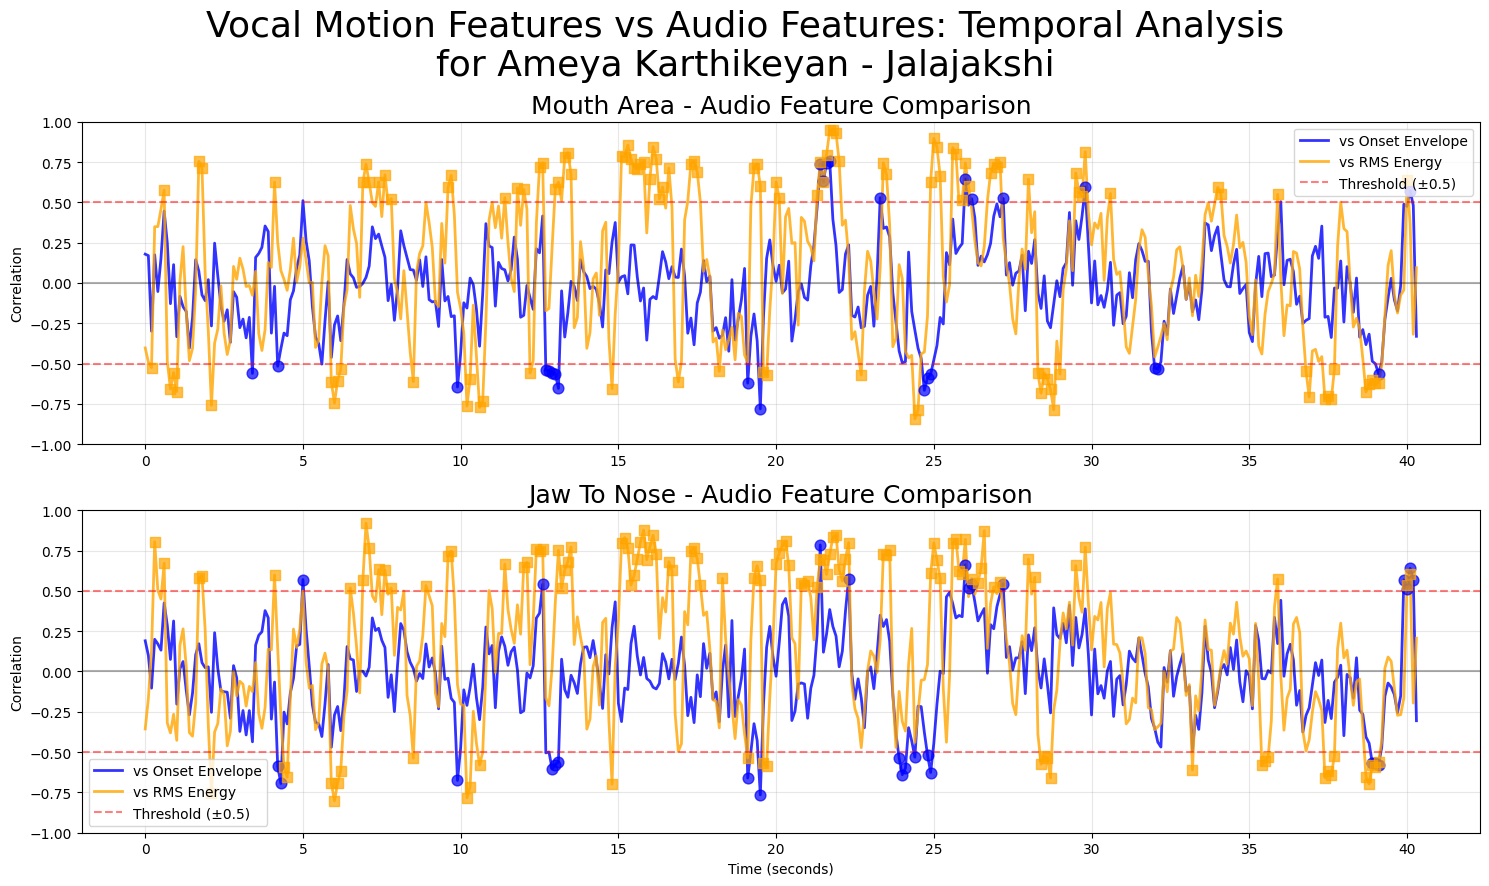


OVERALL AUDIO FEATURE COMPARISON SUMMARY
Total strong correlation windows:
  Onset Envelope: 55
  RMS Energy: 242

✓ RMS Energy overall shows better correlation with vocal motion features!


In [8]:
# Summary and visualization of results with onset env and RMS overlay
import matplotlib.pyplot as plt

print("\n" + "="*60)
print("CORRELATION ANALYSIS SUMMARY - ONSET ENV vs RMS")
print("="*60)

fig, axes = plt.subplots(2, 1, figsize=(15, 9))
fig.suptitle(f'Vocal Motion Features vs Audio Features: Temporal Analysis\nfor {artist} - {song}', fontsize=26)

for i, motion_feature in enumerate(motion_features_to_analyze):
    results = vocal_strong_windows[artist][song][instrument][motion_feature]
    
    ax = axes[i]
    
    # Plot both onset and RMS correlations
    ax.plot(results["times_onset"], results["correlations_onset"], 
            alpha=0.8, linewidth=2, color='blue', label='vs Onset Envelope')
    ax.plot(results["times_rms"], results["correlations_rms"], 
            alpha=0.8, linewidth=2, color='orange', label='vs RMS Energy')
    
    # Threshold lines
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Threshold (±0.5)')
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows with different markers
    for time, corr in results["strong_windows_onset"]:
        ax.scatter(time, corr, color='blue', s=60, zorder=5, marker='o', alpha=0.7)
    
    for time, corr in results["strong_windows_rms"]:
        ax.scatter(time, corr, color='orange', s=60, zorder=5, marker='s', alpha=0.7)
    
    ax.set_title(f'{motion_feature.replace("_", " ").title()} - Audio Feature Comparison', fontsize=18)
    if i == 1: ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim(-1, 1)
    
    # Print summary statistics for both audio features
    correlations_onset = np.array(results["correlations_onset"])
    correlations_rms = np.array(results["correlations_rms"])
    
    print(f"\n{motion_feature.upper()} COMPARISON:")
    print(f"  ONSET ENVELOPE:")
    print(f"    Mean correlation: {np.nanmean(correlations_onset):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_onset):.3f}")
    print(f"    Strong correlation windows: {results['num_strong_windows_onset']}")
    print(f"    % of time with strong correlation: {results['num_strong_windows_onset'] / len(correlations_onset) * 100:.1f}%")
    
    print(f"  RMS ENERGY:")
    print(f"    Mean correlation: {np.nanmean(correlations_rms):.3f}")
    print(f"    Max correlation: {np.nanmax(correlations_rms):.3f}")
    print(f"    Strong correlation windows: {results['num_strong_windows_rms']}")
    print(f"    % of time with strong correlation: {results['num_strong_windows_rms'] / len(correlations_rms) * 100:.1f}%")
    
    # Determine which audio feature correlates better
    onset_pct = results['num_strong_windows_onset'] / len(correlations_onset) * 100
    rms_pct = results['num_strong_windows_rms'] / len(correlations_rms) * 100
    
    if rms_pct > onset_pct:
        print(f"  → RMS energy shows better correlation ({rms_pct:.1f}% vs {onset_pct:.1f}%)")
    else:
        print(f"  → Onset envelope shows better correlation ({onset_pct:.1f}% vs {rms_pct:.1f}%)")

plt.tight_layout()
plt.show()

# Overall comparison summary
print(f"\n{'='*60}")
print("OVERALL AUDIO FEATURE COMPARISON SUMMARY")
print(f"{'='*60}")

total_onset_windows = sum(vocal_strong_windows[artist][song][instrument][feat]['num_strong_windows_onset'] 
                         for feat in motion_features_to_analyze)
total_rms_windows = sum(vocal_strong_windows[artist][song][instrument][feat]['num_strong_windows_rms'] 
                       for feat in motion_features_to_analyze)

print(f"Total strong correlation windows:")
print(f"  Onset Envelope: {total_onset_windows}")
print(f"  RMS Energy: {total_rms_windows}")

if total_rms_windows > total_onset_windows:
    print(f"\n✓ RMS Energy overall shows better correlation with vocal motion features!")
else:
    print(f"\n✓ Onset Envelope overall shows better correlation with vocal motion features!")


COMPARISON: GENERAL vs VOCAL-SPECIFIC MOTION FEATURES


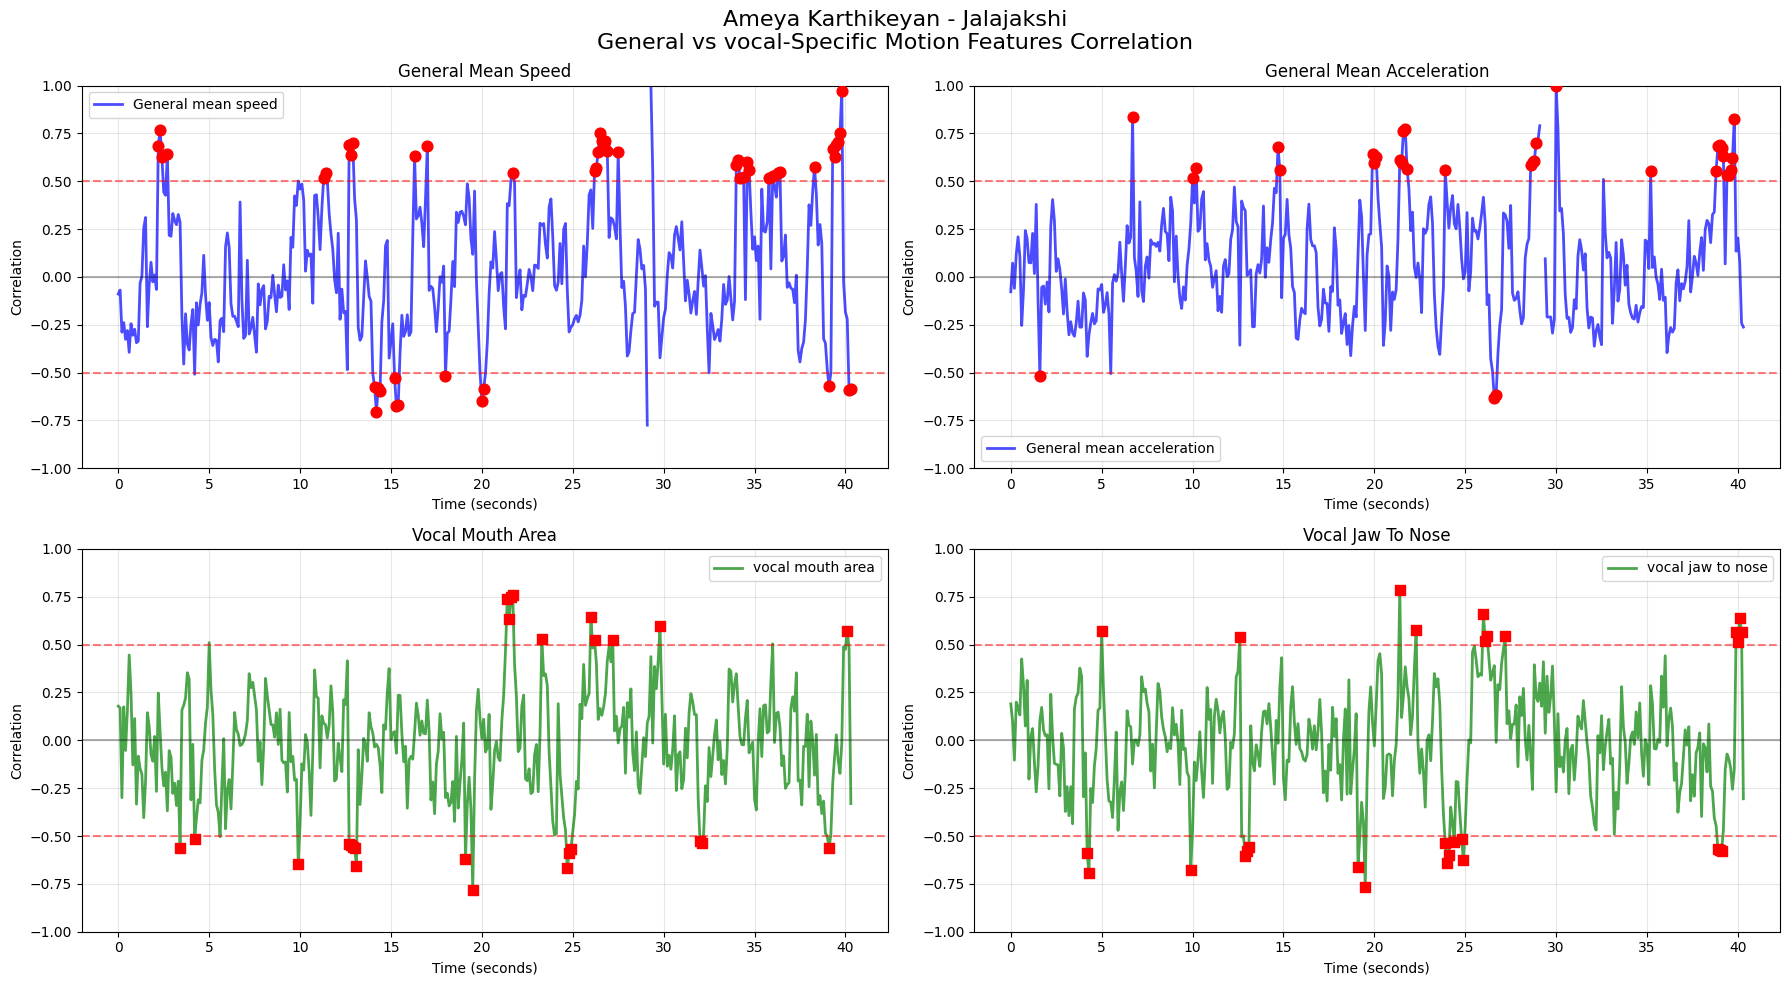

In [10]:
# Comparison analysis: General vs vocal-specific motion features
print("\n" + "="*80)
print("COMPARISON: GENERAL vs VOCAL-SPECIFIC MOTION FEATURES")
print("="*80)

# Get results from both analyses (assuming they're stored in different variables)
# General motion features results (from cell 5)
general_features = ["mean_speed", "mean_acceleration"]

# Create comparison data structure
comparison_data = {}

# Add general motion features data
for feature in general_features:
    motion_data = motion_features["general"][feature]
    correlations, times, strong_windows_list = sliding_correlation(
        motion_data, audio_onset_env, window_size, step_size, fps, threshold=0.5
    )
    comparison_data[f"general_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "general"
    }

# Add vocal-specific motion features data
for feature in motion_features_to_analyze:
    motion_data = vocal_motion_features[feature]
    correlations, times, strong_windows_list = sliding_correlation(
        motion_data, audio_onset_env, window_size, step_size, fps, threshold=0.5
    )
    comparison_data[f"vocal_{feature}"] = {
        "correlations": correlations,
        "times": times,
        "strong_windows": strong_windows_list,
        "type": "vocal"
    }

# Create comprehensive comparison plot
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
fig.suptitle(f'{artist} - {song}\nGeneral vs vocal-Specific Motion Features Correlation', fontsize=16)

# Plot general features in top row
for i, feature in enumerate(general_features):
    ax = axes[0, i]
    data = comparison_data[f"general_{feature}"]
    
    ax.plot(data["times"], data["correlations"], alpha=0.7, linewidth=2, 
            color='blue', label=f'General {feature.replace("_", " ")}')
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color='red', s=60, zorder=5, marker='o')
    
    ax.set_title(f'General {feature.replace("_", " ").title()}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    ax.legend()

# Plot vocal features in bottom row
for i, feature in enumerate(motion_features_to_analyze):
    ax = axes[1, i]
    data = comparison_data[f"vocal_{feature}"]
    
    ax.plot(data["times"], data["correlations"], alpha=0.7, linewidth=2, 
            color='green', label=f'vocal {feature.replace("_", " ")}')
    ax.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=-0.5, color='r', linestyle='--', alpha=0.5)
    ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    # Mark strong correlation windows
    for time, corr in data["strong_windows"]:
        ax.scatter(time, corr, color='red', s=60, zorder=5, marker='s')
    
    ax.set_title(f'Vocal {feature.replace("_", " ").title()}')
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Correlation')
    ax.grid(True, alpha=0.3)
    ax.set_ylim(-1, 1)
    ax.legend()

plt.tight_layout()
plt.show()